In [1]:
import sys
sys.path.append('/Users/Malachite/Documents/UW/ARA/ARA-Plumes/')
from models import PLUME

## Instantiate PLUME object

In [2]:
video_path = "/Users/Malachite/Documents/UW/ARA/ARA-Plumes/plume_videos/July_20/video_high_2/high_2.MP4"
plume_learner = PLUME(video_path=video_path)

plume_leak_source = (1586, 1017)
plume_learner.orig_center = plume_leak_source

fixed_range = 4*119+34
img_range = [fixed_range,1920]

## Apply Concentric Circles

Creating background image...
done.


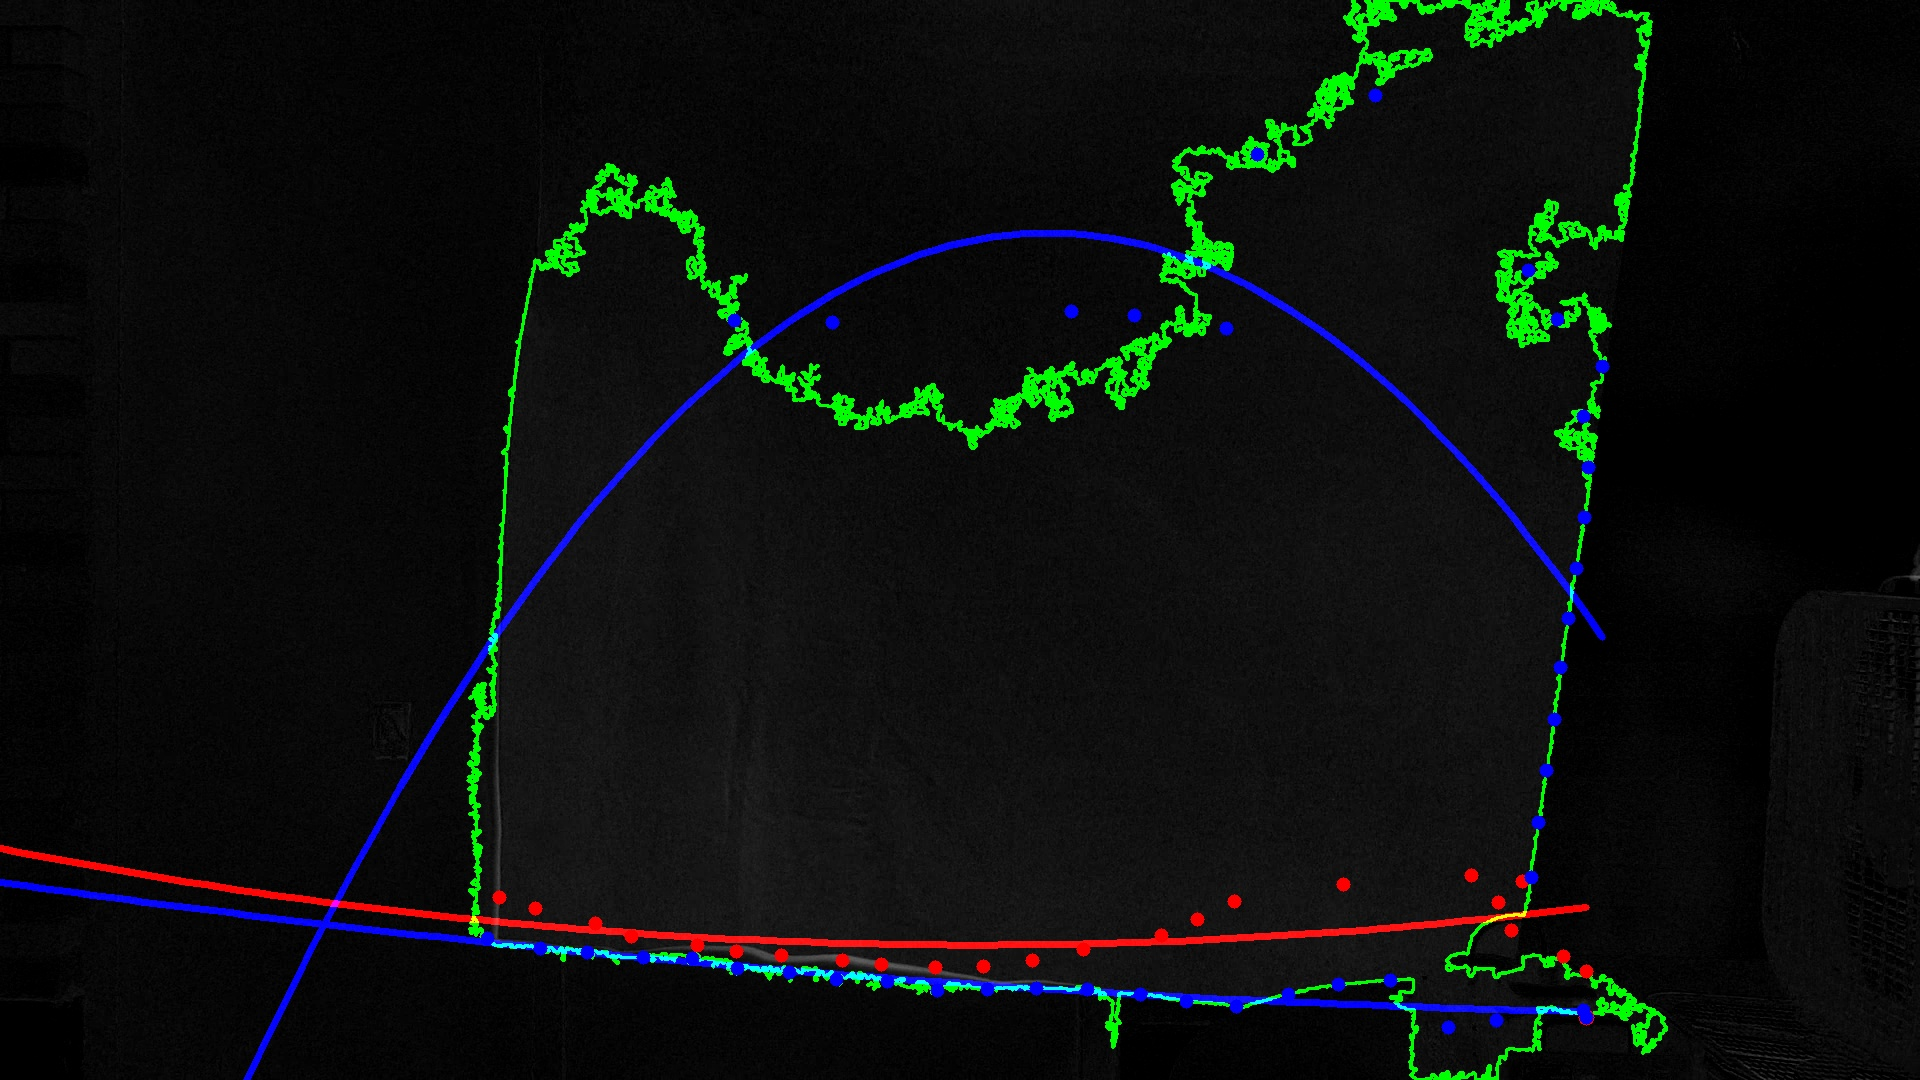

 88%|████████▊ | 1241/1410 [14:59<02:09,  1.31it/s]

In [3]:
output = plume_learner.train(img_range=img_range, fixed_range=fixed_range, save_path="tracked" )

In [ ]:
plume_learner.count

In [ ]:
fixed_range + 899

In [ ]:
plume_learner.tot_frames